# Figure of model residence time

In [75]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import numpy as np
import xarray as xr
import cmocean
import pickle
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import ListedColormap
import matplotlib
import forcing.modules.mapping_functions as mf

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
jsize = jmax-jmin
isize = imax-imin

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1598,2177,777,797) # Northern Canada Basin
bdy_WCB = (2167,2177,390,797) # Western Canada Basin
bdy_LS  = (1140,1150,446,672) # Baffin Bay
bdy_HB  = (1190,1472,291,301) # Hudson Bay

# Colors:
land_color         = '#a9a7a2'
land_outline_color = '#373736'
g           = '#c1c1c1'
markers     = ["o","s","<",">","v","P","3","^","*","D", "d"]

#### Load files:

In [3]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mfile    = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon = mfile['nav_lon'].values
mesh_lat = mfile['nav_lat'].values
mask     = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values
mesh_dz      = np.diff(mesh_depth, prepend=0)

In [4]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
hdept = mesh['hdept'].values[0,:,:]

In [5]:
# Observed Pb residence times:
# Pb residence time estimates from the literature: 
# integrations were performed simply by dividing the water column into intervals defined by the midpoints between sampling depths 
# and weighting each data point according to the depth interval it represented,

#-----------------------------------------------------------------------------------------------------------
# Kadko et al., 2018: collected August 20 - October 5, 2015 ---- residence time of dissolved Pb
kadko_lats      = np.array([76.511, 79.997, 83.755, 87.520, 88.407, 89.987, 87.815, 85.135, 82.491, 80.369, 78.180, 77.503, 76.998, \
                  76.505, 73.506, 73.008])
kadko_lons      = np.array([-173.034, -174.962, 174.915, -179.809, -176.761, -89.25, -149.734, -150.063, -149.872, -149.855, -147.831, -148.009, -148.803, \
                  -149.515, -156.808, -158.729])
kadko_depths    = np.array([56, 52, 52, 46, 20, 23, 45, 41, 47, 49, 40, 47, 40, 40, 46, 36])
kadko_res       = np.array([0.69, 0.76, 0.94, 0.24, 0.76, 0.27, 0.33, 0.71, 1.07, 0.65, 0.31, 0.36, 0.41, 0.28, 0.38, 0.18])
# Residence times are average based on the surface to the given depth, so calculate the average depth:
kadko_ave_depth = (kadko_depths + 0) / 2.
# Find indeces within ANHA12 domain
kadko_ANHA12_i, kadko_ANHA12_j = mf.find_indeces_vector(kadko_lons, kadko_lats, mesh_lon, mesh_lat) 

#-----------------------------------------------------------------------------------------------------------
# Chen et al., 2012: Chukchi Sea / Bering Strait ---- residence time of Pb-210
chen_lats   = np.array([69.996, 73.998, 68.919, 70.495, 71.579, 71.261, 73.995, 73.380])
chen_lons   = np.array([-168.999, -168.991, -167.009, -162.976, -164.013, -150.376, -156.332, -151.883])
chen_depth  = np.array([30,40,10,30,40,20,30,100])
chen_res    = np.array([17,37,5,54,11,36,85,103])/365. # given initially in units of days
# Average depth based on average of sampled depths listed in table 1
chen_ave_depth = np.array([13, 23.3, 5, 15, 22, 10, 15, 50])
# Find indeces within ANHA12 domain
chen_ANHA12_i,  chen_ANHA12_j  = mf.find_indeces_vector(chen_lons, chen_lats, mesh_lon, mesh_lat) 

#-----------------------------------------------------------------------------------------------------------
# Moore and Smith, 1986: Arctic Ocean ---- residence time of dissolved Pb-210
MS_ave_depth = [130., (50+0)/2., (1200+255)/2.] # first number is in the nutrient maximum
MS_restime   = [1.5, 5, 21] 

#-----------------------------------------------------------------------------------------------------------
# Smith et al., 2003: Arctic Ocean ---- residence time of dissolved Pb-210
smith_ave_depth = [(0+50)/2., (0+50)/2., (10+25+50)/3., (10+25+40+50)/4., (10+44)/2., (2000+2000+410)/3.]
smith_restime   = [0.1, 2.2, 0.3, 0.3, 1.0, 30] # range of values observed

#-----------------------------------------------------------------------------------------------------------
# Nozaki et al., 1976: Pacific Ocean ---- residence time of Pb-210
nozaki_restime   = [1.7]    
nozaki_ave_depth = [10./2]  # don't specify the depth in paper other than surface  
 
#-----------------------------------------------------------------------------------------------------------
# Nozaki et al., 1996: Bering Sea ---- residence time of Pb-210
Nozaki_1996_ave_depth = [(1442+1922+2588+3069+3547)/5., (1000+1250+1500+1750+2000+2250+2510+2963+3209+3456+3703+3950+4328+4576+4825+5073+5322+5570)/18.]
Nozaki_1996_restime   = [10, 52]

#-----------------------------------------------------------------------------------------------------------
# Chung and Craig, 1983: North Pacific  ---- residence time of Pb-210
Chung_ave_depth = [610, 3260, 4760]
Chung_restime   = [28, 52, 32]

#-----------------------------------------------------------------------------------------------------------
# Cochran et al., 1995: Arctic ---- residence time of Pb-210
Cochran_1995_ave_depth = [(1500+3000)/2.]
Cochran_1995_restime   = [19]

#-----------------------------------------------------------------------------------------------------------
# Cochran et al., 1990: North Atlantic and North Pacific ---- residence time of Pb-210
Cochran_1990_ave_depth = [(6092+0)/2., (3718+0)/2., (3324+0)/2., (3850+0)/2., (4476+0)/2., (2184+0)/2.]
Cochran_1990_restime   = [91, 30, 42, 48, 36, 22] # first value is north pacific

#-----------------------------------------------------------------------------------------------------------
# Baskaran et al., 2022: Arctic Ocean ---- residence time of total Pb-210
baskaran_2022_ave_depth = [(3925)/2., (2166)/2., (3781)/2., (1601)/2., (500)/2., (500)/2., (500)/2., (500)/2., (500)/2., (1919+2219)/2., (3517+3817)/2.]
baskaran_2022_restime   = [149, 60, 23, 11.2, 6.9, 4.9, 5.5, 4.6, 6.2, 21, 41]
# use station 48 and 56 for spatial tuning too!

#-----------------------------------------------------------------------------------------------------------
# Wangjiang et al., 2014: Arctic Ocean ---- residence time of dissolved Pb-210, sampled 2008, not certain about trustworthiness
wangjiang_2014_lons      = [-168-(59.1/60), -161-(58.9/60), -158-(57.69/60), -158-(19.5/60), -151-(59.7/60), -147-(3.36/60)]
wangjiang_2014_lats      = [71+(59.87/60), 71+(29.17/60), 72+(30.7/60), 72+(56.3/60), 74+(59.7/60), 85+(7.83/60)]
wangjiang_2014_ave_depth = [(40+0)/2.,(40+0)/2.,(40+0)/2.,(60+0)/2.,(60+0)/2.,(60+0)/2.]
wangjiang_2014_restime   = [1.06, 2.28, 1.09, 1.70, 7.49, 5.57]

#### Functions

In [6]:
def load_monthly_comp(folder, year, month):
    # Load file of monthly average:    
    comp = xr.open_dataset(f'{folder}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc')

    dpb      = comp['dissolpb'].values[0,:,:,:] # dissolved Pb concentration
    dpb_ads  = comp['dpbads'].values[0,:,:,:]   # scavenging removal
    
    return dpb, dpb_ads

In [7]:
def calc_annual_residence_time(folder, year):
    
    dPb_total  = np.zeros((50,isize,jsize))
    scav_total = np.zeros((50,isize,jsize))
    for month in range(1,13):
        dPb, dPb_ads = load_monthly_comp(folder, year, month)
        dPb_total    = dPb_total  + dPb
        scav_total   = scav_total + dPb_ads 
    
    # Inventory of [dPb]:
    inventory = np.copy(dPb_total)
    
    # Removal rate of [dPb]:
    removal   = np.copy(scav_total)
    
    # Calculate residence time:
    res_time  = inventory / removal
    
    # Convert residence time from seconds to years:
    residence_time = res_time / (3600*24*365)
    
    return residence_time

In [8]:
def calc_summer_residence_time(folder, year):
    
    dPb_total  = np.zeros((50,isize,jsize))
    scav_total = np.zeros((50,isize,jsize))
    for month in range(8,11):
        dPb, dPb_ads = load_monthly_comp(folder, year, month)
        dPb_total    = dPb_total  + dPb
        scav_total   = scav_total + dPb_ads 
    
    # Inventory of [dPb]:
    inventory = np.copy(dPb_total)
    
    # Removal rate of [dPb]:
    removal   = np.copy(scav_total)
    
    # Calculate residence time:
    res_time  = inventory / removal
    
    # Convert residence time from seconds to years:
    residence_time = res_time / (3600*24*365)
    
    return residence_time

In [9]:
def match_depth(obs_depth):
    # Match nearest depth of observations to index in model:
    
    match_depth_model = np.empty(len(obs_depth))
    for d, depth in enumerate(obs_depth):
        match_depth_model[d] = np.argmin(np.abs(mesh_depth - depth))
    
    return match_depth_model

In [10]:
def create_legend_sources(axis, markers, loc_leg=(0,0)):
    
    s1,  = axis.plot([-20,-20], [0,0], '.', markeredgecolor='w', markeredgewidth=0.0, \
                     label=r'$\bf{Observations:}$', markersize=7, color='w')      
    s2,  = axis.plot([-20,-20], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Kadko et al., 2018: Arctic', markersize=5, color=g, marker=markers[0])
    s3,  = axis.plot([-20,-20], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Baskaran et al., 2022: Arctic', markersize=5, color=g, marker=markers[1])
    s4,  = axis.plot([-20,-20], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Chen et al., 2012: Arctic, Bering', markersize=5, color=g, marker=markers[2])
    s5,  = axis.plot([-20,-20], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Chung and Craig, 1983: Pacific', markersize=5, color=g, marker=markers[3])
    s6,  = axis.plot([-20,-20], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Cochran et al., 1990: Atlantic, Pacific', markersize=5, color=g, marker=markers[4])
    s7,  = axis.plot([-20,-20], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Cochran et al., 1995: Arctic', markersize=5, color=g, marker=markers[5]) 
    s8,  = axis.plot([-20,-20], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Moore and Smith, 1986: Arctic', markersize=5, color=g, marker=markers[6])
    s9,  = axis.plot([-20,-20], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Nozaki et al., 1976: Pacific', markersize=5, color=g, marker=markers[7]) 
    s10, = axis.plot([-20,-20], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Nozaki et al., 1996: Bering', markersize=7, color=g, marker=markers[8])
    s11, = axis.plot([-20,-20], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Smith et al., 2003: Arctic', markersize=4, color=g, marker=markers[9])
    s12, = axis.plot([-20,-20], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Wangjiang et al., 2014: Arctic', markersize=5, color=g, marker=markers[10]) 
    
    leg1 = fig.legend(handles=[s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12], loc=loc_leg, fontsize=7, frameon=False)

    return leg1

In [11]:
def calc_regional_restime_profile(residence_time):
    # Function to calculate mean profiles of residence time for each of the 4 regions
    
    # Separate based on region:
    CB_residence_time  = np.ma.masked_where(CB_mask[:,imin:imax,jmin:jmax]!=1 , residence_time)
    CAA_residence_time = np.ma.masked_where(CAA_mask[:,imin:imax,jmin:jmax]!=1, residence_time)
    BB_residence_time  = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]!=1 , residence_time)
    LS_residence_time  = np.ma.masked_where(LS_mask[:,imin:imax,jmin:jmax]!=1 , residence_time)
    
    # and mask land:
    CB_residence_time  = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), CB_residence_time)
    CAA_residence_time = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), CAA_residence_time)
    BB_residence_time  = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), BB_residence_time)
    LS_residence_time  = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), LS_residence_time)

    # Calculate mean over each of the regions:
    CB_mean_restime    = np.ma.mean(CB_residence_time , axis=(1,2))
    CAA_mean_restime   = np.ma.mean(CAA_residence_time, axis=(1,2))
    BB_mean_restime    = np.ma.mean(BB_residence_time , axis=(1,2))
    LS_mean_restime    = np.ma.mean(LS_residence_time , axis=(1,2))

    mean_restime = {'CB':CB_mean_restime.filled(fill_value=np.nan), 'CAA':CAA_mean_restime.filled(fill_value=np.nan), \
                    'BB':BB_mean_restime.filled(fill_value=np.nan), 'LS':LS_mean_restime.filled(fill_value=np.nan)}
    return mean_restime

In [58]:
def plot_regional(axis, tau, colors, legend=True):
        
    s1 = axis.plot([-20,-20], [0,0], '.',  markeredgewidth=0.0, label=r'$\bf{Region:}$', markersize=0)  
    axis.plot(tau['LS'] , mesh_depth, color=colors[0], label='Labrador Sea' , linewidth=1.8, linestyle=(0,(1,1)))
    axis.plot(tau['BB'] , mesh_depth, color=colors[1], label='Baffin Bay'   , linewidth=1.8, linestyle='-')
    axis.plot(tau['CAA'], mesh_depth, color=colors[2], label='Canadian Arctic Archipelago', linewidth=1.8, linestyle='-')
    axis.plot(tau['CB'] , mesh_depth, color=colors[3], label='Canada Basin' , linewidth=1.8, linestyle=(0,(1,1)))
    
    # Manually set the position and relative size of the inset axes within ax1    
    axis.tick_params(labelsize=7, pad=0)
    axis.xaxis.tick_top()    
    axis.xaxis.set_label_position('top') 
    
    if legend:
        fig.legend(loc=(0.08, 0.3), fontsize=7, frameon=False)    
    return

#### Calculations

Create mask for different regions to create average profiles over:

In [12]:
# Average basin profiles for different regions 
# --- Canada Basin ---
CB_mask  = np.zeros(bathy_masked.shape)
CB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CB_mask[depth][mesh_lon > -80]   = 0
    CB_mask[depth][hdept < 2000]     = 0

CB_mask[mesh_bathy < 0.1] = 0

# --- CAA ---
CAA_mask = np.zeros(bathy_masked.shape)
CAA_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CAA_mask[depth][hdept > 500]     = 0
    CAA_mask[depth][mesh_lon < -130] = 0
    CAA_mask[depth][mesh_lon > -40]  = 0
    CAA_mask[depth][mesh_lat < 65]   = 0
    CAA_mask[depth][(mesh_lat < 75) & (mesh_lon >-75)] = 0
    
CAA_mask[mesh_bathy < 0.1] = 0

# --- Baffin Bay ---
BB_mask  = np.zeros(bathy_masked.shape)
BB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BB_mask[depth][mesh_lon < -75]   = 0
    BB_mask[depth][hdept < 1000]     = 0
    BB_mask[depth][mesh_lat <= 65]   = 0
    BB_mask[depth][mesh_lat > 80]    = 0

BB_mask[mesh_bathy < 0.1] = 0
    
# --- Labrador Sea ---
LS_mask  = np.zeros(bathy_masked.shape)
LS_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    LS_mask[depth][mesh_lon < -75]   = 0
    LS_mask[depth][mesh_lat > 65]    = 0
    LS_mask[depth][hdept < 2000]     = 0
    
LS_mask[mesh_bathy < 0.1] = 0

In [13]:
# Collect all observations into two lists:

all_obs_ave_depth = []
all_obs_ave_depth.extend(kadko_ave_depth)
all_obs_ave_depth.extend(baskaran_2022_ave_depth)
all_obs_ave_depth.extend(chen_ave_depth)
all_obs_ave_depth.extend(Chung_ave_depth)
all_obs_ave_depth.extend(Cochran_1990_ave_depth)
all_obs_ave_depth.extend(Cochran_1995_ave_depth)
all_obs_ave_depth.extend(MS_ave_depth)
all_obs_ave_depth.extend(nozaki_ave_depth)
all_obs_ave_depth.extend(Nozaki_1996_ave_depth)
all_obs_ave_depth.extend(smith_ave_depth)
all_obs_ave_depth.extend(wangjiang_2014_ave_depth)

all_obs_restime = []
all_obs_restime.extend(kadko_res)
all_obs_restime.extend(baskaran_2022_restime)
all_obs_restime.extend(chen_res)
all_obs_restime.extend(Chung_restime)
all_obs_restime.extend(Cochran_1990_restime)
all_obs_restime.extend(Cochran_1995_restime)
all_obs_restime.extend(MS_restime)
all_obs_restime.extend(nozaki_restime)
all_obs_restime.extend(Nozaki_1996_restime)
all_obs_restime.extend(smith_restime)
all_obs_restime.extend(wangjiang_2014_restime)

In [14]:
# create list of model depth indices associated with depths of observations:
all_model_depth_ind = match_depth(all_obs_ave_depth)

In [70]:
# load and calculate annual residence time estimate: 
folder_base = '/data/brogalla/run_storage/Pb-reference-202303/'
restime_array = np.zeros((50,1040,640))
for year in range(2002,2020):
    print(year)
    annual_restime = calc_annual_residence_time(f'{folder_base}Pb-reference-{year}_20230308/', year)
    restime_array += annual_restime
    
ts_ave_restime      = restime_array / len(range(2002,2020))
ts_regional_restime = calc_regional_restime_profile(ts_ave_restime)

2002


/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [64]:
annual_restime = calc_annual_residence_time(f'{folder_base}Pb-reference-2010_20230308/', 2010)
summer_restime = calc_summer_residence_time(f'{folder_base}Pb-reference-2010_20230308/', 2010) 

mean_restime = calc_regional_restime_profile(annual_restime)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


#### Figure:


In [65]:
color_regions = ['#23343f','#23343f', '#699dbd','#699dbd'] ##a5c4d7 #['#d2e1eb','#699dbd','#46697e','#23343f']

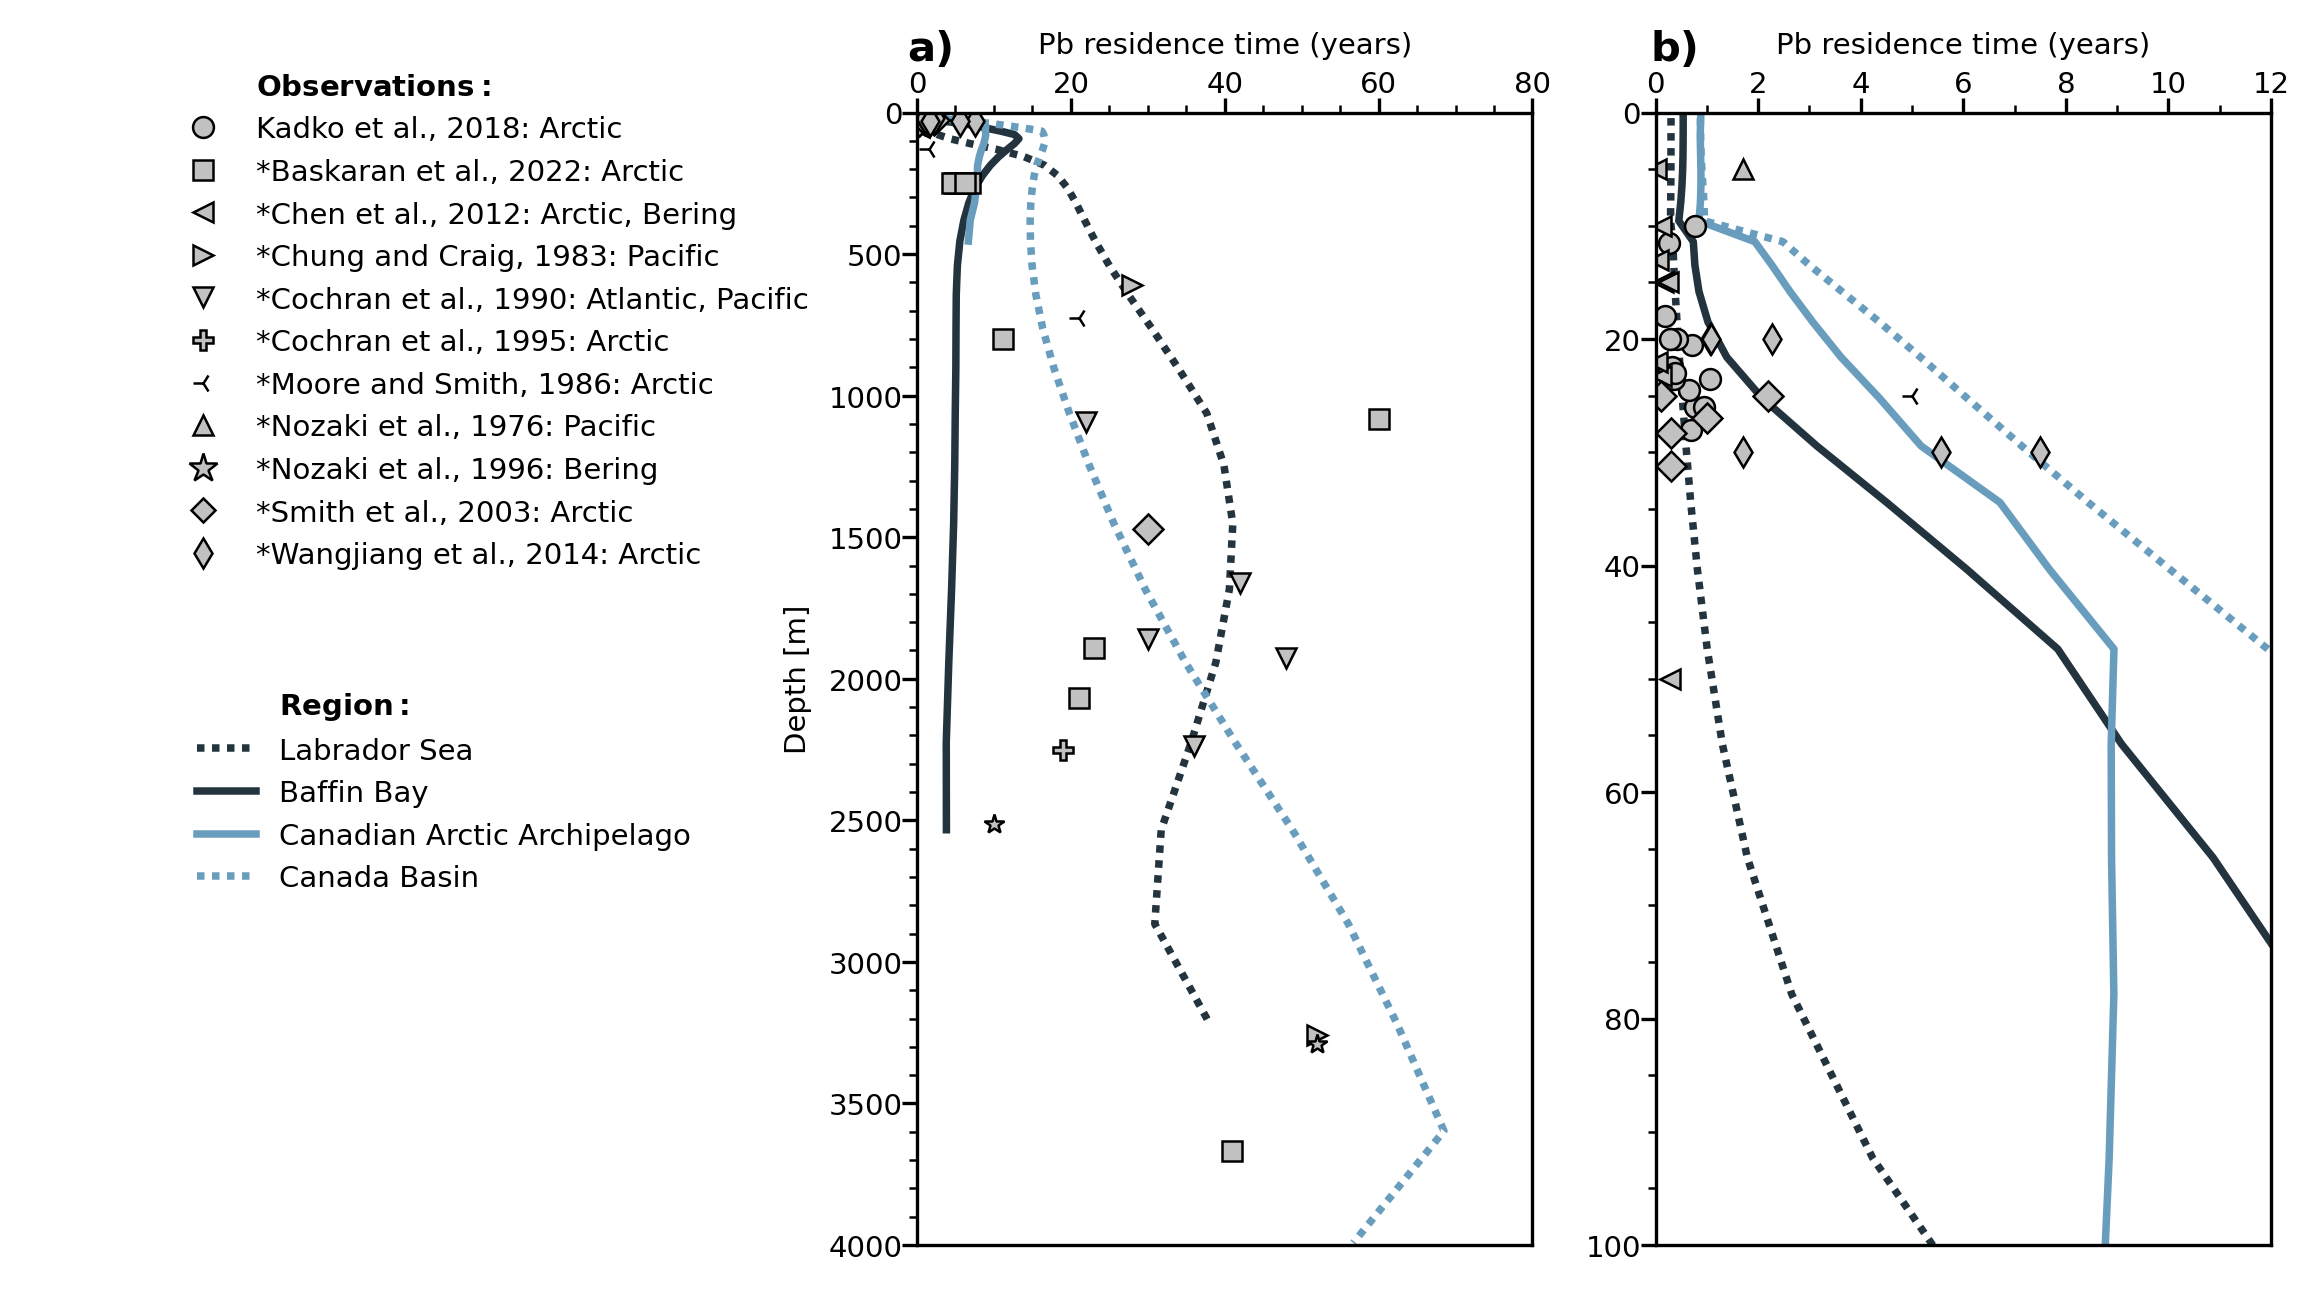

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(9,5), dpi=300)
ax[0].axis('off')

#------------- Vertical profile ----------------
ax[1].set_ylabel('Depth [m]', fontsize=7)
for axis in [ax[1], ax[2]]:
    axis.set_xlabel('Pb residence time (years)', fontsize=7)
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top') 
    axis.yaxis.set_minor_locator(MultipleLocator(100))
    axis.xaxis.set_minor_locator(MultipleLocator(5))
    
plot_regional(ax[1], ts_regional_restime, color_regions, legend=True)
plot_regional(ax[2], ts_regional_restime, color_regions, legend=False)

ax[2].xaxis.set_minor_locator(MultipleLocator(1))
ax[2].yaxis.set_minor_locator(MultipleLocator(5))
ax[1].set_ylim(4000,0);
ax[2].set_ylim(100,0);     
ax[1].set_xlim(0,80)
ax[2].set_xlim(0,12)

# Observations: --------------------------------------------------------------------------
kwargs={'markeredgecolor':'k', 'markeredgewidth':0.6, 'markersize':5, 'linestyle':'', 'color':g}
for axis in [ax[1],ax[2]]:
    axis.plot(kadko_res             , kadko_ave_depth         , marker=markers[0], **kwargs)
    axis.plot(baskaran_2022_restime , baskaran_2022_ave_depth , marker=markers[1], **kwargs)
    axis.plot(chen_res              , chen_ave_depth          , marker=markers[2], **kwargs)
    axis.plot(Chung_restime         , Chung_ave_depth         , marker=markers[3], **kwargs)
    axis.plot(Cochran_1990_restime  , Cochran_1990_ave_depth  , marker=markers[4], **kwargs)
    axis.plot(Cochran_1995_restime  , Cochran_1995_ave_depth  , marker=markers[5], **kwargs)
    axis.plot(MS_restime            , MS_ave_depth            , marker=markers[6], **kwargs)
    axis.plot(nozaki_restime        , nozaki_ave_depth        , marker=markers[7], **kwargs)
    axis.plot(Nozaki_1996_restime   , Nozaki_1996_ave_depth   , marker=markers[8], **kwargs)
    axis.plot(smith_restime         , smith_ave_depth         , marker=markers[9], **kwargs)
    axis.plot(wangjiang_2014_restime, wangjiang_2014_ave_depth, marker=markers[10], **kwargs)

leg1 = create_legend_sources(ax[1], markers, loc_leg=(0.07,0.55))

fig.text(0.395, 0.915, 'a)', fontsize=10, weight='bold');
fig.text(0.670, 0.915, 'b)', fontsize=10, weight='bold');
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/R3-residence-time.jpg', bbox_inches='tight', dpi=300)